# Generate Figure 1: Overview


In [1]:
from latticegen import hexlattice_gen_fast
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.patheffects as patheffects
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import dask.array as da
import pyGPA.geometric_phase_analysis as GPA
from pyGPA.imagetools import trim_nans, to_KovesiRGB, fftplot
import pyGPA.property_extract as pe
from dask_image.imread import imread
from moisan2011 import per
import colorcet
import xarray as xr

%matplotlib inline

glasbey = plt.get_cmap('cet_glasbey_dark')(np.linspace(0, 1, 255))

cmap_seq = plt.get_cmap('plasma')(np.linspace(0, 1, 6))

In [2]:
folder = './data'

IVname = '20200714_111905_5.7um_494.7_IVhdr_layercounts_data.nc'

IV = xr.open_dataset(os.path.join(folder, IVname), chunks='auto')
IVdc = IV.Intensity.data
IV

<xarray.Dataset>
Dimensions:      (time: 802, x: 1322, y: 1069)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-14T11:19:16 ... 2020-07-14T12:...
  * x            (x) float64 0.0 3.7 7.4 11.1 ... 4.88e+03 4.884e+03 4.888e+03
  * y            (y) float64 0.0 3.7 7.4 11.1 ... 3.944e+03 3.948e+03 3.952e+03
Data variables:
    Intensity    (time, x, y) uint16 dask.array<chunksize=(312, 515, 416), meta=np.ndarray>
    Pressure     (time) float64 dask.array<chunksize=(802,), meta=np.ndarray>
    Multiplier   (time) float64 dask.array<chunksize=(802,), meta=np.ndarray>
    Energy       (time) float64 dask.array<chunksize=(802,), meta=np.ndarray>
    Energy_set   (time) float64 dask.array<chunksize=(802,), meta=np.ndarray>
    Temperature  (time) float64 dask.array<chunksize=(802,), meta=np.ndarray>
Attributes:
    dataset identifier:  20200714_111905_5.7um_494.7_IVhdr_layercounts

## Experimental IV curves

In [3]:
IVcoords = np.array([[962,  999],
                     [834,  247],
                     [650,  600],
                     [597,  615],
                     [617, 1109],
                     [501,  190],
                     [377,  236]]
                    )

IVcoords = np.array([[984, 1017],
                    [555, 1102],
                    [690, 852],
                    [510, 250],
                    [530, 380]]
                    )
labels = ['mono', 'bi', 'tri', 'quad', 'quin']
EGY = IV.Energy.data.compute()
multiplier = IV.Multiplier.data.compute()
rsize = 20

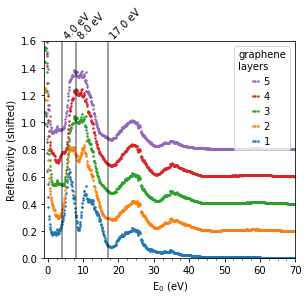

In [4]:
dat = []

for i, coord in enumerate(IVcoords):
    x = slice(int(coord[0])-rsize, int(coord[0])+rsize)
    y = slice(int(coord[1])-rsize, int(coord[1])+rsize)
    dat.append(IVdc[:, y, x].mean(axis=(1, 2)) / multiplier)
fig, axs = plt.subplots(figsize=[4.5, 4])
for i, coord in enumerate(IVcoords):
    axs.plot(EGY[EGY > -1], dat[i][EGY > -1] + 0.2*i,
             '.', label=str(i+1), markersize=3)
axs.xaxis.set_minor_locator(ticker.MultipleLocator(2.5))
axs.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

axs.set_xlim(-1, 70)
axs.set_ylim(0, 1.6)
axs.set_ylabel('Reflectivity (shifted)')
axs.set_xlabel('$E_0$ (eV)')
handles, labels = plt.gca().get_legend_handles_labels()
axs.legend(handles[::-1], labels[::-1], title='graphene\nlayers', loc='upper right', numpoints=3, handlelength=0.1)
for E in [4., 8., 17.]:
    axs.axvline(E, color='black', alpha=0.5)
    axs.text(E, 1.6, f'{E:.1f} eV', rotation=45, ha='left', va='bottom')

In [5]:
np.argmin(np.abs(EGY-8))

178

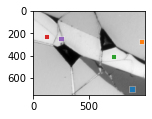

In [6]:
fig, ax = plt.subplots(figsize=[2, 2])
renderi = 178
IVim = np.where(IVdc[renderi] == 0, np.nan, IVdc[renderi])[150:1150, 300:1050]
ax.imshow(IVim.T, cmap='gray')
for i, c in enumerate(IVcoords - np.array([300, 150])):
    rect = plt.Rectangle(c[::-1], 2*rsize, 2*rsize,
                         color=f'C{i}',
                         fill=True, alpha=0.99, lw=0.1,
                         path_effects=[patheffects.withStroke(linewidth=2, foreground="white", alpha=0.3)]
                         )
    ax.add_artist(rect)

## Composite image

In [7]:
colordata = xr.open_dataset(os.path.join(folder, 'composite_overview.nc'), chunks='auto').Intensity.data
colordata

dask.array<open_dataset-af44827d12c29c46191179154c820f49Intensity, shape=(8436, 11199, 4), dtype=float32, chunksize=(2812, 3733, 1), chunktype=numpy.ndarray>

64171129 pixels


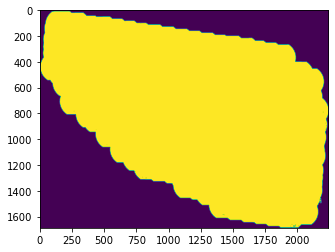

In [8]:
full_mask = ~np.all(np.isnan(colordata), axis=-1)
print(full_mask.sum().compute(), 'pixels')
plt.imshow(full_mask[::5, ::5])

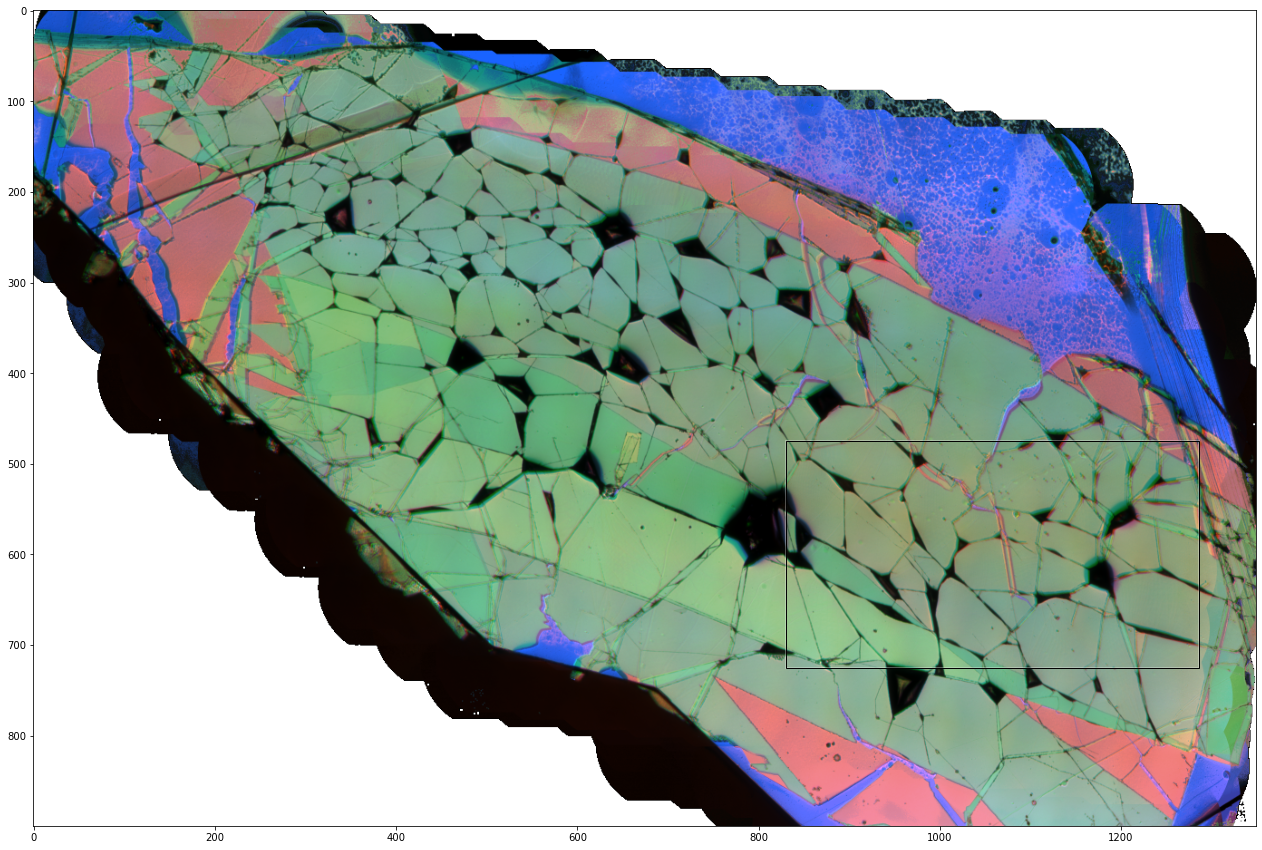

In [9]:
zc = 8
z = 2
rgbim = da.coarsen(np.mean, colordata, {1: zc, 0: zc}, trim_excess=True).compute()
coarsemask = da.coarsen(np.min, full_mask, {1: zc, 0: zc}, trim_excess=True).compute()[..., None]
rgbim = rgbim[..., [3, 0, 2]]
rgbim = rgbim - np.nanquantile(rgbim, 0.01, axis=(0, 1))
rgbim = rgbim / np.nanquantile(rgbim, 0.99, axis=(0, 1))
rgbim = np.clip(rgbim, 0, 1)
rgbim = np.concatenate([to_KovesiRGB(rgbim), coarsemask[..., :]], axis=-1)[300//zc:7500//zc, 200//zc:-200//zc]
plt.figure(figsize=[25, 15])
plt.imshow(rgbim)
cropx, cropy = slice(6100//z, 9750//z), slice(3150//z, 5150//z)
rect = plt.Rectangle([cropx.start*z/zc+540/zc, cropy.start*z/zc+650/zc],
                     (cropx.stop-cropx.start)*z//zc,
                     (cropy.stop-cropy.start)*z//zc,
                     edgecolor='black',
                     fill=False, alpha=0.99, lw=1,
                     path_effects=[patheffects.withStroke(linewidth=2, foreground="white", alpha=0.3)])
plt.gca().add_artist(rect)

## Areas

In [10]:
coordsl = np.array([[850.69462839, 4398.48610047],
                   [3642.89786153, 5400.49488182],
                   [3721.72436096, 6384.55472946],
                   [3507.55425954, 8281.36876338],
                   [4271.33017045, 7833.81755442],
                   [3380.03002363, 6921.11024705],
                   [2735.31323933, 4710.03264254],
                   [4812.93836045, 7729.48655758],
                   [363.96565178, 1325.27028875],
                   [4099.87750689, 9225.98507689],
                   #[4187.6835177 , 6938.49991558],
                    [4137.6835177, 6908.49991558],
                    [3807.04299538, 7066.02415149]])
#spm = 78
thetas = np.array([0.08231551, 0.12645036, 0.16555969, 0.18013369, 0.22943989,
                   0.26136647, 0.26864944, 0.3158437, 0.42540967, 0.46494363,
                   0.62684929, 0.63126423])
sprimes = np.array([130, 173, 166, 234, 164, 166,  78, 145,  94, 132, 109,  78])

In [11]:
dbov_name = "20200713_163811_5.7um_501.2_sweep-STAGE_X-STAGE_Y_domainboundaries_stitch_v10_2020-11-20_1649_sobel_4_bw_200.tif"
dbov_image = imread(os.path.join(folder, dbov_name)).squeeze()

In [12]:
NMPERPIXEL = 3.7
sindices2 = [3, 5, 9, 10]
#sdp = sprimes[sindices2]
#spm = np.min(sdp)
# print(spm)
spm = 109
coordsll = coordsl[sindices2]

In [13]:
NMPERPIXEL = 3.7
#sindices2 = [0,3,5,9,10]
sindices2 = [3, 5, 9, 10]
sdp = sprimes[sindices2]
spm = np.min(sdp)
print(spm)
coordsll = coordsl[sindices2]

109


## Domain boundaries overview

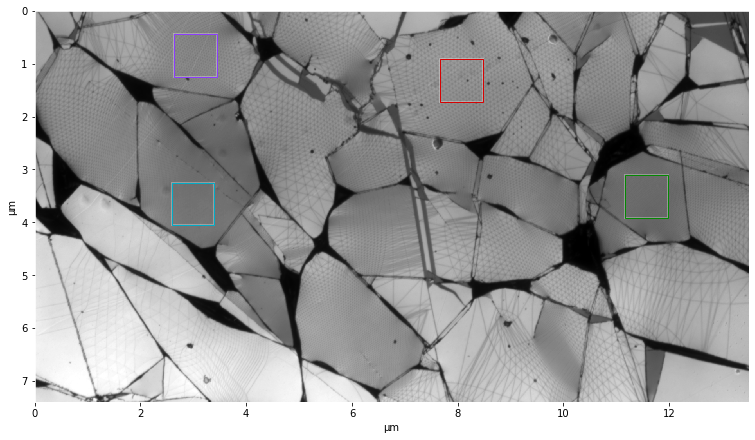

In [14]:
z = 2

cropx, cropy = slice(6100//z, 9750//z), slice(3150//z, 5150//z)

zim = da.coarsen(np.mean, dbov_image, {1: z, 0: z}, trim_excess=True).compute()[cropy, cropx]
pltim = trim_nans(np.where(zim <= 20, np.nan, zim))
fig, ax = plt.subplots(figsize=[12, 6], constrained_layout=True)
im = ax.imshow(pltim, cmap='gray',
               vmin=np.nanquantile(zim, 0.001), vmax=np.nanquantile(zim, 0.999),
               interpolation='none')
im.set_extent(np.array(im.get_extent())*z*NMPERPIXEL/1e3)
ax.set_xlabel('μm')
ax.set_ylabel('μm')
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_color("white")

ax.patch.set_alpha(0.5)
for i, coord in enumerate(coordsll - z*np.array([cropy.start, cropx.start])):
    rect = plt.Rectangle(coord[[1, 0]]*NMPERPIXEL/1e3-spm*NMPERPIXEL/1e3,
                         2*spm*NMPERPIXEL/1e3, 2*spm*NMPERPIXEL/1e3,
                         edgecolor=glasbey[i],
                         fill=False, alpha=0.99, lw=1,
                         path_effects=[patheffects.withStroke(linewidth=2, foreground="white", alpha=0.3)])
    ax.add_artist(rect)

# Theory curves

In [15]:
IVcalcs = xr.open_dataset(os.path.join(folder,
                                       'stacking_reflectivity_calculations_bilayer_graphene.nc'),
                          chunks='auto')
tEGY = IVcalcs.Energy.data

# Compensate for mismatch between ab-initio calculations and experiments
tEGY -= 5
tEGY *= 1.04

Text(65, 0.065, 'AA')

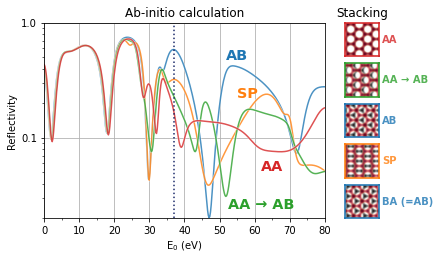

In [16]:
r_k = 0.02
theta = 0
shape = (200, 200)
steps = 6
a_0 = 0.246
shift = np.array([2/steps/r_k, 0])
iterated0 = hexlattice_gen_fast(r_k, 0, 1, shape).compute()

layout = """
    ab
    ac
    ad
    ae
    af
"""
lcmap = 'RdGy_r'

fig = plt.figure(figsize=[6, 3.5], constrained_layout=True)
path_set = [patheffects.withStroke(linewidth=2.5, foreground="white", alpha=0.6)]
axs = fig.subplot_mosaic(layout,
                         gridspec_kw={  # "height_ratios": [0.6, 1.4],
                             "width_ratios": [6, 1],
                         })
ax = axs['a']
for index, label in zip([0, 4, 12, 16], ['AB = AC', 'DW', 'AB → AA', 'AA']):
    ax.semilogy(tEGY, gaussian_filter1d(IVcalcs.Reflectivity[index], sigma=3, axis=0),
                linewidth=1.5,
                label=label, path_effects=path_set, alpha=0.8)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_xlim(0, 80)
ax.set_ylim(2e-2, 1)
ax.grid(which='major')


ax.axvline(37, color='#001158', alpha=0.9, linestyle='dotted')
ax.set_ylabel('Reflectivity')
ax.set_xlabel('$E_0$ (eV)')


ax = [axs[l] for l in 'bcdef']
iterated0 /= iterated0.max()
labels = ['AA', 'AA → AB', 'AB', 'SP', 'BA (=AB)']
colors = ['C3', 'C2', 'C0', 'C1', 'C0']
stackextent = [-shape[0]*r_k*a_0, shape[0]*r_k*a_0, shape[1]*r_k*a_0, -shape[1]*r_k*a_0]
for i in range(steps-1):
    iterated2 = hexlattice_gen_fast(r_k, 0, 1, shape, shift=shift*i).compute()
    iterated2 /= iterated2.max()
    ax[i].imshow(-iterated0.T, cmap=lcmap,
                 extent=stackextent,
                 vmax=1, vmin=-1,
                 alpha=np.clip(iterated0, 0, 1).T
                 )
    ax[i].imshow(iterated2.T, cmap=lcmap,
                 extent=stackextent,
                 vmax=1, vmin=-1,
                 alpha=np.clip(iterated2.T*0.9, 0, 1)
                 )
    ax[i].text(1.1, 0.5, labels[i], transform=ax[i].transAxes, verticalalignment='center',
               fontdict=dict(color=colors[i], fontweight='bold', alpha=0.8))
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[i].spines[axis].set_linewidth(2)
        ax[i].spines[axis].set_color(colors[i])
        ax[i].spines[axis].set_alpha(0.8)
        ax[i].tick_params(axis='both', which='both',
                          labelleft=False, labelright=False,
                          labelbottom=False, length=0)
axs['a'].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.1f}'))
ax[0].set_title('Stacking')
axs['a'].set_title('Ab-initio calculation')
annotatekwargs = dict(fontweight='bold', fontsize='x-large',
                      horizontalalignment='center', verticalalignment='top')
axs['a'].annotate('AB',
                  (55, 0.6),
                  color='C0', **annotatekwargs)
axs['a'].annotate('SP',
                  (58, 0.28),
                  color='C1', **annotatekwargs)
axs['a'].annotate('AA → AB',
                  (62., 0.03),
                  color='C2', **annotatekwargs)
axs['a'].annotate('AA',
                  (65, 0.065),
                  color='C3', **annotatekwargs)

# Combined overview
Version 2

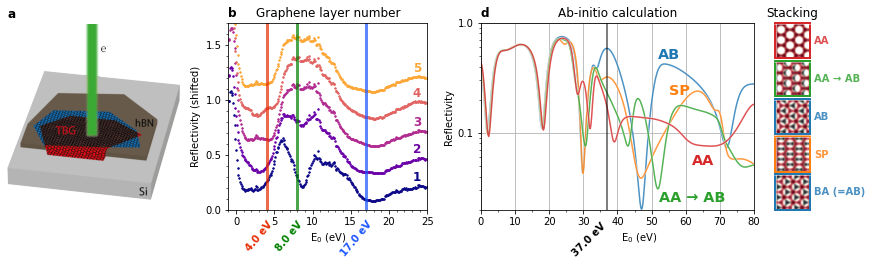

In [23]:
layout = """
    nabc
    nabd
    nabe
    nabf
    nabg
"""

fig = plt.figure(figsize=[12, 3.5], constrained_layout=True)
axs = fig.subplot_mosaic(layout,
                         gridspec_kw={  # "height_ratios": [0.6, 1.4],
                             "width_ratios": [3.5, 4, 5.5, 1],
                         })
ax = axs['b']
for index, label in zip([0, 4, 12, 16], ['AB = AC', 'DW', 'AB → AA', 'AA']):
    ax.semilogy(tEGY, gaussian_filter1d(IVcalcs.Reflectivity[index], sigma=3, axis=0),
                linewidth=1.5,
                label=label, path_effects=path_set, alpha=0.8)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_xlim(0, 80)
ax.set_ylim(2e-2, 1)
ax.grid(which='major')


ax.set_ylabel('Reflectivity')
ax.set_xlabel('              $E_0$ (eV)')


#fig, ax = plt.subplots(nrows=steps-1, figsize=[3,6], constrained_layout=True)
ax = [axs[l] for l in 'cdefg']
iterated0 /= iterated0.max()
labels = ['AA', 'AA → AB', 'AB', 'SP', 'BA (=AB)']
colors = ['C3', 'C2', 'C0', 'C1', 'C0']
for i in range(steps-1):
    iterated2 = hexlattice_gen_fast(r_k, 0, 1, shape, shift=shift*i).compute()
    iterated2 /= iterated2.max()
    ax[i].imshow(-iterated0.T, cmap=lcmap,
                 vmax=1,
                 vmin=-1,
                 alpha=np.clip(iterated0.T, 0, 1),
                 # interpolation='none'
                 )
    ax[i].imshow(iterated2.T, cmap=lcmap,
                 vmax=1,
                 vmin=-1,
                 alpha=np.clip(iterated2.T, 0, 1)*0.9,
                 # interpolation='none'
                 )
    ax[i].text(1.1, 0.5, labels[i], transform=ax[i].transAxes, verticalalignment='center',
               fontdict=dict(color=colors[i], fontweight='bold', alpha=0.8))
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[i].spines[axis].set_linewidth(2)
        ax[i].spines[axis].set_color(colors[i])
        ax[i].spines[axis].set_path_effects(path_set)
        ax[i].tick_params(axis='both', which='both',
                          labelleft=False, labelright=False,
                          labelbottom=False, length=0)
        # ax[i].set_axis_off()
axs['b'].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.1f}'))
ax[0].set_title('Stacking')
axs['b'].set_title('Ab-initio calculation')

for i, coord in enumerate(IVcoords):
    axs['a'].plot(EGY[EGY > -1], dat[i][EGY > -1] + 0.25*i,
                  '.', label=str(i+1), markersize=3, color=cmap_seq[i])
    axs['a'].annotate(str(i+1), (EGY[340], dat[i][340].compute() + 0.25*i+0.02),
                      xycoords='data',
                      horizontalalignment='right',
                      verticalalignment='bottom',
                      color=cmap_seq[i],
                      fontweight='bold', fontsize='large'
                      )
axs['a'].xaxis.set_minor_locator(ticker.MultipleLocator(1))
axs['a'].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs['a'].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
axs['a'].set_xlim(-1, 25)
axa_upperlim = 1.7
axs['a'].set_ylim(0, axa_upperlim)
axs['a'].set_ylabel('Reflectivity (shifted)')
axs['a'].set_xlabel('$E_0$ (eV)')
handles, labels = axs['a'].get_legend_handles_labels()

axs['a'].set_title('Graphene layer number')


# Get Kovesi base colors
colors = to_KovesiRGB(np.eye(3))
for i, E in enumerate([4., 8., 17.]):
    axs['a'].axvline(E, color=colors[i], alpha=0.7, linewidth=3)

    axs['a'].text(E+1., -0.08, f'{E:.1f} eV', rotation=50,
                  ha='right', va='top', color=colors[i], fontweight='bold')
axs['b'].axvline(37., color='black', alpha=0.5, linewidth=2)

axs['b'].text(37, 0.016, f'37.0 eV', rotation=45,
              ha='right', va='top', fontweight='bold')
axs['a'].set_title('b', loc='left', fontweight='bold')
axs['b'].set_title('d', loc='left', fontweight='bold')
axs['n'].set_title('a', loc='left', fontweight='bold')
annotatekwargs = dict(fontweight='bold', fontsize='x-large',
                      horizontalalignment='center', verticalalignment='top')
axs['b'].annotate('AB',
                  (55, 0.6),
                  color='C0', **annotatekwargs)
axs['b'].annotate('SP',
                  (58, 0.28),
                  color='C1', **annotatekwargs)
axs['b'].annotate('AA → AB',
                  (62., 0.03),
                  color='C2', **annotatekwargs)
axs['b'].annotate('AA',
                  (65, 0.065),
                  color='C3', **annotatekwargs)
schematic = imread(os.path.join(folder, 'Figure1a.png')).compute().squeeze()
axs['n'].imshow(schematic)
axs['n'].set_axis_off()
axs['n'].tick_params(axis='both', which='both',
                          labelleft=False, labelright=False,
                          labelbottom=False, length=0)
fig.set_constrained_layout_pads(hspace=2/72, h_pad=0.5/72)
fig.savefig(os.path.join('figures', 'overviewtop2_2.pdf'), dpi=600)

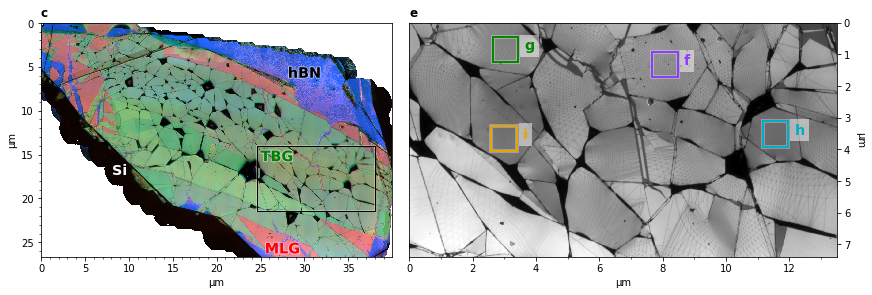

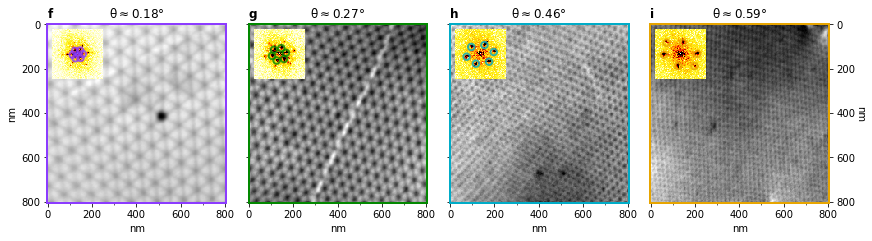

In [18]:
layout = """
    ce
"""
# efghi
fig = plt.figure(figsize=[12, 4.], constrained_layout=True)
ax = fig.subplot_mosaic(layout,
                        gridspec_kw={  # "height_ratios": [0.6, 1.4],
                            # "width_ratios": [1.8, 0.2, 1,1,1],
                            "width_ratios": [2.46, 3],
                        })

fig2, ax2 = plt.subplots(ncols=4, figsize=[12, 3.3], constrained_layout=True)

im = ax['e'].imshow(pltim, cmap='gray',
                    vmin=np.nanquantile(zim, 0.001), vmax=np.nanquantile(zim, 0.999),
                    interpolation='none')
im.set_extent(np.array(im.get_extent())*z*NMPERPIXEL/1e3)
for l in 'ce':
    ax[l].set_xlabel('μm')
    ax[l].set_ylabel('μm')

ax['e'].patch.set_alpha(0.5)
ax['e'].yaxis.tick_right()
ax['e'].yaxis.set_label_position("right")
ax['e'].set_ylabel('μm', rotation=-90, labelpad=15)
ax['e'].tick_params(axis='y', which='both', labelleft=False, labelright=True)


ax['c'].xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax['c'].yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax['e'].xaxis.set_minor_locator(ticker.MultipleLocator(1))

labelindices = "fghij"
for i, coord in enumerate(coordsll):
    rect = plt.Rectangle((coord - z*np.array([cropy.start, cropx.start]))[[1, 0]]*NMPERPIXEL/1e3 - spm*NMPERPIXEL/1e3,
                         2*spm*NMPERPIXEL/1e3, 2*spm*NMPERPIXEL/1e3,
                         edgecolor=glasbey[i+1],
                         fill=False, alpha=0.99, lw=2,
                         path_effects=[patheffects.withStroke(linewidth=4, foreground="white", alpha=0.3)])
    ax['e'].add_artist(rect)
    ax['e'].annotate(labelindices[i], (coord -
                                       z *
                                       np.array([cropy.start, cropx.start]))[[1, 0]] *
                     NMPERPIXEL /
                     1e3 +
                     np.array([spm *
                               NMPERPIXEL /
                               1e3 +
                               0.19, -
                               spm *
                               NMPERPIXEL /
                               1e3 +
                               0.062]), fontweight='bold', color=glasbey[i +
                                                                         1], horizontalalignment='left', verticalalignment='top', fontsize='x-large', bbox=dict(fc="white", ec="none", alpha=0.5))
    a = ax2[i]
    x = slice(int(coord[0])-spm, int(coord[0])+spm)
    y = slice(int(coord[1])-spm, int(coord[1])+spm)
    lim = dbov_image[x, y].compute().astype(float)
    pks, _ = GPA.extract_primary_ks(lim, pix_norm_range=(4, 50), sigma=1.5)
    props = pe.Kerelsky_plus(pks, nmperpixel=NMPERPIXEL, sort=1)
    a.set_title(f"$\\theta \\approx ${props[0]:.2f}°")
    im = a.imshow(lim,
                  vmax=np.quantile(lim, 0.99999),
                  vmin=np.quantile(lim, 0.00001),
                  cmap='gray', interpolation='none')
    im.set_extent(np.array(im.get_extent())*NMPERPIXEL)
    p, _ = per(lim-lim.mean(), inverse_dft=False)
    fftim = np.abs(np.fft.fftshift(p))
    axin = inset_axes(a, width="28%", height="28%", loc=2)
    axin.tick_params(labelleft=False, labelbottom=False, direction='in', length=0)
    for axis in ['top', 'bottom', 'left', 'right']:
        axin.spines[axis].set_color(None)

    fftplot(fftim.T, ax=axin, pcolormesh=False,
            vmax=np.quantile(fftim, 0.995), origin='lower',
            vmin=np.quantile(fftim, 0.01), cmap='cet_fire_r',
            d=NMPERPIXEL, interpolation='none')

    axin.scatter(*(pks/NMPERPIXEL).T[::-1]+0.5/NMPERPIXEL/spm, edgecolor=glasbey[i+1],
                 alpha=0.8, s=42, marker='o', color='none', linewidth=2)
    axin.scatter(*(-pks/NMPERPIXEL).T[::-1]+0.5/NMPERPIXEL/spm, edgecolor=glasbey[i+1],
                 alpha=0.8, s=42, marker='o', color='none', linewidth=2)
    rf = 0.08
    axin.set_xlim([-rf, rf])
    axin.set_ylim([rf, -rf])
    a.xaxis.set_minor_locator(ticker.MultipleLocator(100))
    for axis in ['top', 'bottom', 'left', 'right']:
        a.spines[axis].set_linewidth(2)
        a.spines[axis].set_color(glasbey[i+1])
    a.set_xlabel('nm')
    if i == 0:
        a.set_ylabel('nm')
    elif i == 3:
        a.yaxis.tick_right()
        a.set_ylabel('nm', rotation=-90, labelpad=10)
        a.yaxis.set_label_position("right")
        a.tick_params(axis='y', which='both', labelleft=False, labelright=True)
    else:
        a.tick_params(axis='y', which='both', labelleft=False, labelright=False)
im = ax['c'].imshow(rgbim, interpolation='none')
im.set_extent(np.array(im.get_extent())*zc*NMPERPIXEL/1e3)
rect = plt.Rectangle(np.array([cropx.start*z+540, cropy.start*z+650])*NMPERPIXEL/1e3,
                     (cropx.stop-cropx.start)*z*NMPERPIXEL/1e3,
                     (cropy.stop-cropy.start)*z*NMPERPIXEL/1e3,
                     edgecolor='black',
                     fill=False, alpha=0.99, lw=1,
                     path_effects=[patheffects.withStroke(linewidth=2,
                                                          foreground="white",
                                                          alpha=0.3)])
ax['c'].add_artist(rect)
annotatekwargs = dict(fontsize='x-large', fontweight='bold',
                      horizontalalignment='center', verticalalignment='top',
                      path_effects=[patheffects.withStroke(linewidth=2,
                                                           foreground="white",
                                                           alpha=0.5)])

ax['c'].annotate('Si', [9, 16],
                 color='white', **{**annotatekwargs, 'path_effects': None})
ax['c'].annotate('hBN', [30, 5],
                 color='black', **annotatekwargs)
ax['c'].annotate('TBG', [25, 14.5],
                 color='green', **{**annotatekwargs, 'horizontalalignment': 'left'})
ax['c'].annotate('MLG', [27.5, 25],
                 color='red', **annotatekwargs)


for key in ax.keys():
    ax[key].set_title(key, loc='left', fontweight='bold')

for key, a in zip(labelindices, ax2):
    a.set_title(key, loc='left', fontweight='bold')
fig.savefig(os.path.join('figures', 'overviewcenter2_2.pdf'))
fig2.savefig(os.path.join('figures', 'overviewbottom2_2.pdf'))